In [1]:
# Philip Tenteromano
# 11/24/2019
# Deep Learning|
# HW 3 
# Variational Auto Encoder

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### More imports

In [3]:
import matplotlib.pyplot as plt
import cv2
import random
from operator import itemgetter

# Layers
import tensorflow as tf

import keras
from keras.losses import mse, binary_crossentropy, mean_absolute_error
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Reshape
from keras.layers import Layer, Add, Multiply, BatchNormalization, Activation
from keras.initializers import he_normal
from keras.utils import Sequence
from keras.utils.vis_utils import plot_model

import gc

print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.0.0


Using TensorFlow backend.


In [4]:
 
###################################
# TensorFlow wizardry
config = tf.compat.v1.ConfigProto() 
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
###################################


### Get the helper py file to the working dir

In [5]:
from shutil import copyfile

# Copy util file into working directory
copyfile(src = '/kaggle/input/cs-6000deeplearning/helper/helper/utils.py', dst = "../working/utils.py")

# Import the util file
from utils import getFID,lmScore

#### Seed

In [6]:
# 0431 - last four of FIDN
def seed_everything(SEED):
    np.random.seed(SEED)
    try:
        tf.set_random_seed(SEED)
    except:
        tf.random.set_seed(SEED)
    random.seed(SEED)
    
SEED_VAL = 431 
seed_everything(SEED_VAL)

## Helper Functions

In [7]:
# Function to return the a random index
# @size: original length of a given dataset
# @Returns: random idx in range

def rand_idx(size):
    return np.random.randint(0, size - 1)

In [8]:
# Normalize function
# @data: data to be normalized
# @Returns: normalized data in range (0,1)

def normalize(data):
    max_val = np.max(data)
    
    return data / max_val

In [9]:
# Given a filename, returns the integer id of the image
# @img_file: image filename
# @Returns: unique integer id of file/img

def get_img_id(img_file):
    prefix = img_file.split('.')[0]
    _id = int(prefix)
    return _id

In [10]:
# Prints out random image from data
# @data: entire array of image arrays

def show_rand_img(data):
    idx = rand_idx(len(data))
    plt.imshow(data[idx])

In [11]:
# Clears tensorflow to rebuild graphs

def clear_graphs(): 
    keras.backend.clear_session()

In [12]:
# Given just directory name, imports all image files
# @train: default True, import train or test images
# @flag: default 0 (greyscale), integer to import images as grey, unchanged, or color
# @Returns: two vectors, (ids, imgdata), pairwise sorted by id

def import_image_data(train=True, flag=0, all_imgs=True):
    
    if not (0 <= flag < 3):
        return "Flag needs to be between 0 and 2"
    
    flags = [cv2.IMREAD_UNCHANGED, cv2.IMREAD_COLOR, cv2.IMREAD_GRAYSCALE]
    color_scheme = flags[flag]

    root = "/kaggle/input/cs-6000deeplearning/celeba/"
    directory = "train/" if train else "test/"
    data_path = root + directory
    print("Importing Images from " + directory)
    
    # Stores tuples as (id, img array)
    data = [] 

    # Get the directory and list of files in directory
    for path, _, jpg_imgs in os.walk(data_path):
        print("Num Images: " + str(len(jpg_imgs)))
        num_imgs = len(jpg_imgs) if all_imgs else 2000
        
        # Loop through all images and build data list
        for i, img in enumerate(jpg_imgs[:num_imgs]):
            full_path = data_path + img
            img_arr = cv2.imread(full_path, color_scheme)
            
            # Convert back to RGB if colored
            if flag < 2:
                img_arr = cv2.cvtColor(img_arr.astype('float32'), cv2.COLOR_BGR2RGB)
            
            # Resize keeping aspect ratio to best ability
            new_dims = (128, 128)
            img_arr = cv2.resize(img_arr, new_dims, interpolation=cv2.INTER_AREA)
#             print(img_arr.shape)

            # id is found on filename
            _id = get_img_id(img)
            
            # Create tuple and append
            id_arr = (_id, img_arr)
            data.append(id_arr)

            # Output progress every so often
            if i % 6000 == 0 and i != 0: print(i)
                
    # Sort by the index
    sorted_data = sorted(data, key=itemgetter(0))
    
    # Seperate back out into two vectors
    img_ids = [v[0] for v in sorted_data]
    img_data = [v[1] for v in sorted_data]

    del sorted_data
    
    # Normalize the data
    img_ids = np.array(img_ids)
    img_data = normalize(np.array(img_data))
    
    print("Done")
    
    # Return vector of ids pairwise with vector of image data
    return img_ids, img_data


## Import training data

In [13]:
train_idx, train = import_image_data()
len(train)

Importing Images from train/
Num Images: 17902
6000
12000
Done


17902

In [14]:
test_idx, test = import_image_data(train=False)

Importing Images from test/
Num Images: 1500
Done


In [15]:
try:
    del test_idx
    del train_idx
except:
    pass
gc.collect()

0

### Global Parameters

In [16]:
# Data shape
print("Data Shape:", train.shape)

# Get parameters
input_shape = train.shape[1:]
latent_dim = 128

Data Shape: (17902, 128, 128, 3)


<hr>

# Start VAE

## KL Divergence Custom Layer

In [17]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

### Encoder Model

In [18]:
# Four total max pools
def vae_encoder(k=4, activ_func='relu'):
    
    # Pool size
    p = 2
    
    # He initialization
    w_init = he_normal(SEED_VAL)
    
    params = {'padding': 'same', 'strides': 1, 'kernel_initializer': w_init}
    
    # Matrix input
    global inputs
    inputs = Input(shape=input_shape, name='VAE_input')

    # Layer 1
    x = Conv2D(filters=112, 
                    kernel_size=(k-1,k-1), 
                    **params,
                    name='L_1')(inputs)
    x = BatchNormalization(name='BN_1')(x)
    x = Activation(activ_func, name='A_1')(x)

    # Layer 2
    x = Conv2D(filters=100, 
                    kernel_size=(k-1,k-1), 
                    **params,
                    name='L_2')(x)
    x = BatchNormalization(name='BN_2')(x)
    x = Activation(activ_func, name='A_2')(x)

    # Layer 3
    x = Conv2D(filters=88, 
                    kernel_size=(k-1,k-1), 
                    **params,
                    name='L_3')(x)
    x = BatchNormalization(name='BN_3')(x)
    x = Activation(activ_func, name='A_3')(x)

    # Layer 4 - with Max pool
    x = Conv2D(filters=76, 
                    kernel_size=(k-1,k-1), 
                    **params,
                    name='L_4')(x)
    x = BatchNormalization(name='BN_4')(x)
    x = Activation(activ_func, name='A_4')(x)
    x = MaxPooling2D(pool_size=(p,p), padding='same', name='MP_4')(x)

    # Layer 5
    x = Conv2D(filters=64, 
                    kernel_size=(k,k), 
                    **params,
                    name='L_5')(x)
    x = BatchNormalization(name='BN_5')(x)
    x = Activation(activ_func, name='A_5')(x)

    # Layer 6 - with Max pool
    x = Conv2D(filters=52, 
                    kernel_size=(k,k), 
                    **params,
                    name='L_6')(x)
    x = BatchNormalization(name='BN_6')(x)
    x = Activation(activ_func, name='A_6')(x)
    x = MaxPooling2D(pool_size=(p,p), padding='same', name='MP_6')(x)
    
    # Layer 7 
    x = Conv2D(filters=40, 
                    kernel_size=(k,k), 
                    **params,
                    name='L_7')(x)
    x = BatchNormalization(name='BN_7')(x)
    x = Activation(activ_func, name='A_7')(x)
    
    # Layer 8 - with Max pool
    x = Conv2D(filters=28, 
                    kernel_size=(k,k), 
                    **params,
                    name='L_8')(x)
    x = BatchNormalization(name='BN_8')(x)
    x = Activation(activ_func, name='A_8')(x)
    x = MaxPooling2D(pool_size=(p,p), padding='same', name='MP_8')(x)
    
    # Layer 9
    x = Conv2D(filters=20, 
                    kernel_size=(k,k), 
                    **params,
                    name='L_9')(x)
    x = BatchNormalization(name='BN_9')(x)
    x = Activation(activ_func, name='A_9')(x)
    
    # Layer 10 - with Max pool
    x = Conv2D(filters=16, 
                     kernel_size=(k,k), 
                     **params,
                     name='L_10')(x)
    x = BatchNormalization(name='BN_10')(x)
    x = Activation(activ_func, name='A_10')(x)
    x = MaxPooling2D(pool_size=(p,p), padding='same', name='MP_10')(x)
    
    # Layer 11
    x = Conv2D(filters=12,
                     kernel_size=(k,k),
                     **params, 
                     name='L_11')(x)
    x = BatchNormalization(name='BN_11')(x)
    x = Activation(activ_func, name='A_11')(x)
    
    # Layer 12
    x = Conv2D(filters=8,
                     kernel_size=(k,k),
                     **params,
                     name='L_12')(x)
    x = BatchNormalization(name='BN_12')(x)
    x = Activation(activ_func, name='A_12')(x)
    
    # Layer 13
    x = Conv2D(filters=6, 
                     kernel_size=(k,k), 
                     **params,
                     name='L_13')(x)
    x = BatchNormalization(name='BN_13')(x)
    x = Activation(activ_func, name='A_13')(x)
    
    # Layer 14
    x = Conv2D(filters=4,
                     kernel_size=(k,k),
                     **params,
                     name='L_14')(x)
    x = BatchNormalization(name='BN_14')(x)
    x = Activation(activ_func, name='A_14')(x)

    # Layer 15
    x = Conv2D(filters=2,
                     kernel_size=(k,k), 
                     **params,
                     name='L_15')(x)
    x = BatchNormalization(name='BN_15')(x)
    x = Activation(activ_func, name='A_15')(x)
    
    # Flatten
    x = Flatten()(x)

    # Z layer - Latent Distribution Vectors
    global z_mean
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # Calculate KL divergence of distribution layers
    z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])
    
    # Turn log_var into std_deviation
    z_sigma = Lambda(lambda t: K.exp(.5*t), name='std_dev')(z_log_var)
    
    # Reparameterization trick
    global eps
    eps = Input(tensor=K.random_normal(shape=(K.shape(inputs)[0], latent_dim)), name='epsilon')
    
    # Z is the final output
    z_eps = Multiply(name='sample')([z_sigma, eps])
    global z
    z = Add(name='z_out')([z_mean, z_eps])

    # Combine to create Encoder model
    # Outputs Z distribution
    encoder = Model(inputs=[inputs, eps], outputs=z, name='Encoder_Model')
    encoder.summary()  
    
    return encoder

### Decoder Model

In [19]:
def vae_decoder(k=4, activ_func='relu'):
    
    # He initialization
    w_init = he_normal(SEED_VAL)
    params = {'padding': 'same', 'strides': 1, 'kernel_initializer': w_init}
    
    # Draw inputs and reshape
    latent_inputs = Input(shape=(latent_dim,), name='decoder_inputs')
    x = Reshape((8,8,2), name='L1_decoder')(latent_inputs)
    
    # Layer 1
    x = Conv2D(filters=32, 
                    kernel_size=(k+4,k+4), 
                    **params,
                    name='L_1_decoder')(x)
    x = BatchNormalization(name='BN_1_decoder')(x)
    x = Activation(activ_func, name='A_1_decoder')(x)
    
    # Layer 2 - 2x Transpose
    x = Conv2DTranspose(filters=30, kernel_size=(k+4,k+4), strides=2, padding='same', kernel_initializer=w_init)(x)
    x = BatchNormalization(name='BN_2_decoder')(x)
    x = Activation(activ_func, name='A_2_decoder')(x)
    
    # Layer 3
    x = Conv2D(filters=28, 
                    kernel_size=(k+3,k+3), 
                    **params,
                    name='L_3_decoder')(x)
    x = BatchNormalization(name='BN_3_decoder')(x)
    x = Activation(activ_func, name='A_3_decoder')(x)
    
    

    # Layer 4
    x = Conv2D(filters=24, 
                    kernel_size=(k+3,k+3), 
                    **params,
                    name='L_4_decoder')(x)
    x = BatchNormalization(name='BN_4_decoder')(x)
    x = Activation(activ_func, name='A_4_decoder')(x)
    
    # Layer 5 - 2x Transpose
    x = Conv2DTranspose(filters=22, kernel_size=(k+3,k+3), strides=2, padding='same', kernel_initializer=w_init)(x)
    x = BatchNormalization(name='BN_5_decoder')(x)
    x = Activation(activ_func, name='A_5_decoder')(x)
    
    # Layer 6 
    x = Conv2D(filters=20,
                    kernel_size=(k+2,k+2), 
                    **params,
                    name='L_6_decoder')(x)
    x = BatchNormalization(name='BN_6_decoder')(x)
    x = Activation(activ_func, name='A_6_decoder')(x)
    
    # Layer 7
    x = Conv2D(filters=16,
                    kernel_size=(k+2,k+2), 
                    **params,
                    name='L_7_decoder')(x)
    x = BatchNormalization(name='BN_7_decoder')(x)
    x = Activation(activ_func, name='A_7_decoder')(x)
    
    # Layer 8 
    x = Conv2D(filters=12, 
                    kernel_size=(k+1,k+1),
                    **params,
                    name='L_8_decoder')(x)
    x = BatchNormalization(name='BN_8_decoder')(x)
    x = Activation(activ_func, name='A_8_decoder')(x)
    
    # Layer 9 - with 2x Transpose
    x = Conv2DTranspose(filters=10, kernel_size=(k+1,k+1), strides=2, padding='same', kernel_initializer=w_init)(x)
    x = BatchNormalization(name='BN_9_decoder')(x)
    x = Activation(activ_func, name='A_9_decoder')(x)
    
    # Layer 10 
    x = Conv2D(filters=8, 
                    kernel_size=(k+1,k+1), 
                    **params,
                    name='L_10_decoder')(x)
    x = BatchNormalization(name='BN_10_decoder')(x)
    x = Activation(activ_func, name='A_10_decoder')(x)

    # Layer 11
    x = Conv2D(filters=6,
                    kernel_size=(k,k),
                    **params,
                    name='L_11_decoder')(x)
    x = BatchNormalization(name='BN_11_decoder')(x)
    x = Activation(activ_func, name='A_11_decoder')(x)

    # Layer 12
    x = Conv2D(filters=4, 
                     kernel_size=(k,k), 
                     **params,
                     name='L_12_decoder')(x)
    x = BatchNormalization(name='BN_12_decoder')(x)
    x = Activation(activ_func, name='A_12_decoder')(x)
    
    # Layer 13 - 2x Transpose
    x = Conv2DTranspose(filters=3, kernel_size=(k,k), strides=2, padding='same', kernel_initializer=w_init)(x)
    x = BatchNormalization(name='BN_13_decoder')(x)
    x = Activation(activ_func, name='A_13_decoder')(x)
    
    # Layer 14
    x = Conv2D(filters=3, 
                    kernel_size=(k-1,k-1),
                    **params,
                    name='decoder_output')(x)
    x = BatchNormalization(name='BN_14_decoder')(x)
    
    # Output with sigmoid
    output = Activation('sigmoid', name='A_14_decoder')(x)
    
    # Store the model and return
    decoder = Model(latent_inputs, output, name='Decoder_Model')
    decoder.summary()
  
    return decoder

# Combine into VAE

In [20]:
def vae_model(encoder, decoder, loss_func=mse):
        
    y_hat = decoder(z)
    
    vae = Model(inputs=[inputs, eps], outputs=y_hat, name='VAE')
    
    vae.compile(optimizer='adam', loss=loss_func)
    vae.summary()
    
    return vae

# Build Models

In [21]:
clear_graphs()
encoder = vae_encoder()

Model: "Encoder_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_input (InputLayer)          (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
L_1 (Conv2D)                    (None, 128, 128, 112 3136        VAE_input[0][0]                  
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 128, 128, 112 448         L_1[0][0]                        
__________________________________________________________________________________________________
A_1 (Activation)                (None, 128, 128, 112 0           BN_1[0][0]                       
______________________________________________________________________________________

In [22]:
decoder = vae_decoder()

Model: "Decoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_inputs (InputLayer)  (None, 128)               0         
_________________________________________________________________
L1_decoder (Reshape)         (None, 8, 8, 2)           0         
_________________________________________________________________
L_1_decoder (Conv2D)         (None, 8, 8, 32)          4128      
_________________________________________________________________
BN_1_decoder (BatchNormaliza (None, 8, 8, 32)          128       
_________________________________________________________________
A_1_decoder (Activation)     (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 30)        61470     
_________________________________________________________________
BN_2_decoder (BatchNormaliza (None, 16, 16, 30)      

In [23]:
vae = vae_model(encoder, decoder)

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
VAE_input (InputLayer)          (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
L_1 (Conv2D)                    (None, 128, 128, 112 3136        VAE_input[0][0]                  
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 128, 128, 112 448         L_1[0][0]                        
__________________________________________________________________________________________________
A_1 (Activation)                (None, 128, 128, 112 0           BN_1[0][0]                       
________________________________________________________________________________________________

In [24]:
class data_generator(Sequence):

    def __init__(self, num_points, batch_size, data=train):
        self.x, self.y = data[:num_points], data[:num_points]
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x), np.array(batch_y)

In [25]:
n=100
batch=50
epochs=2
steps_per = np.floor(n / batch)
    
n_test = len(test) if n > len(test) else n
steps_per_test = np.floor(n_test / batch)

# h = vae.fit_generator(data_generator(num_points=n, batch_size=batch),
#                   steps_per_epoch=steps_per, 
#                   epochs=eps, 
#                   shuffle=True,
#                   validation_data=data_generator(data=test, num_points=n_test, batch_size=batch),
#                   validation_steps=steps_per_test,
#                   validation_freq=2,
#                   max_queue_size=5,
#                   use_multiprocessing=True, 
#                   workers=4,
#                   initial_epoch=0)

In [26]:
vae.fit_generator(data_generator(num_points=100, batch_size=50), epochs=2, steps_per_epoch=steps_per)

Epoch 1/2
2/2 [==============================] - 70s 35s/step - loss: 42.8000
Epoch 2/2
2/2 [==============================] - 56s 28s/step - loss: 29.2019


In [27]:
vae.fit(train[:100], train[:100], batch_size=20, epochs=2)

Epoch 1/2
100/100 [==============================] - 56s 560ms/step - loss: 15.2698
Epoch 2/2
100/100 [==============================] - 56s 561ms/step - loss: 5.4107


In [28]:
@tf.function
def train_vae(n=len(train), batch=250, epochs=40):
    gc.collect()
    
    steps_per = np.floor(n / batch)
    
    n_test = len(test) if n > len(test) else n
    steps_per_test = np.floor(n_test / batch)
    
    h = vae.fit_generator(data_generator(num_points=n, batch_size=batch),
                          steps_per_epoch=steps_per, 
                          epochs=eps, 
                          shuffle=True,
                          validation_data=data_generator(data=test, num_points=n_test, batch_size=batch),
                          validation_steps=steps_per_test,
                          validation_freq=2,
                          max_queue_size=5,
                          use_multiprocessing=True, 
                          workers=4,
                          initial_epoch=0)
    
    return h

### Train VAE Model

In [29]:
COMMIT = False

In [30]:
# if COMMIT:
#     h = train_vae()
# else:
#     h = train_vae(n=100, batch=50, epochs=2)

## Bulk plot function

In [31]:
def show_images(data, show_train=True, seq_start=None):
    fig,axes = plt.subplots(nrows = 2, ncols = 10, figsize=(50,10))
    
    rand = True
    if seq_start is not None:
        start = seq_start
        rand = False
    
    img = 0
    idx = 0
    for r in range(2):
        for c in range(10):
            if not rand:
                    idx = start
                    start += 1
                    
            to_plot = train if show_train and img < 10 else data
            
            if rand: idx = rand_idx(len(to_plot))
                
            axes[r,c].imshow(to_plot[idx])
            axes[r,c].axis('off')
            
            img += 1


## Generate New Images Function

In [32]:
def generate_imgs(n=20, sigma=1):
    # mean and standard deviation
    mu = 0
    
    # Get distribution of size (n, 128)
    rand_normal = np.random.normal(mu, sigma, (n,128))
    
    # Feed into latent vector and decode into images
    y_hat = decoder.predict(rand_normal)
    
    return y_hat

In [33]:
# Generate new images
y_hat = generate_imgs()

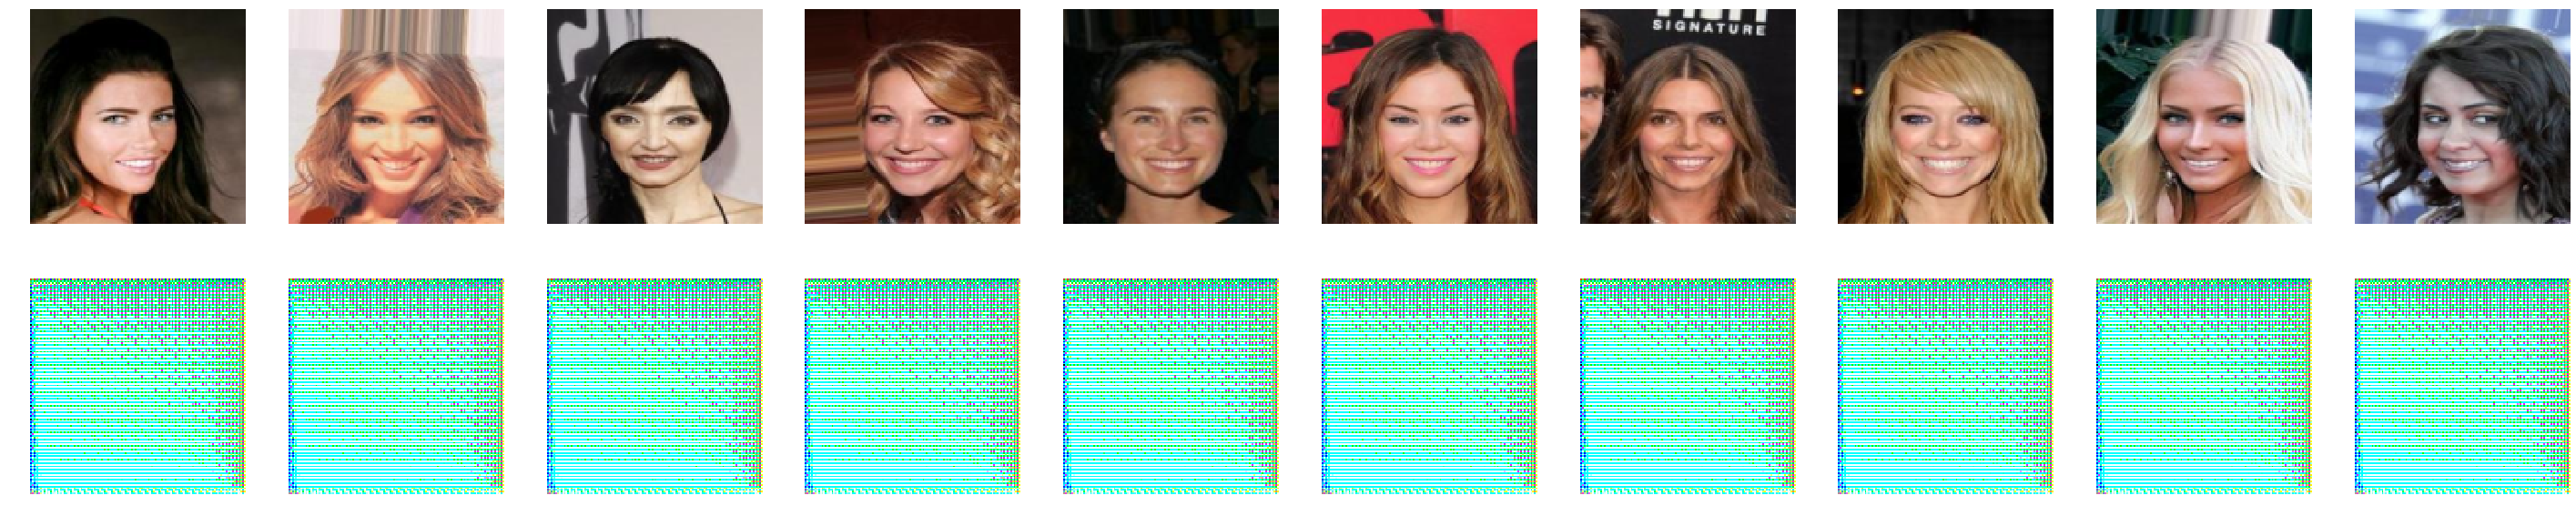

In [34]:
# Plot sequentially
show_images(y_hat, seq_start=0)

## Latent Vectors Function

In [35]:
def get_latent_vectors(n=20, data=test):
    samples = data[:n]
    
    latent_vecs = encoder.predict(samples)
    
    return latent_vecs.reshape(-1, 16, 8)

In [36]:
lv = get_latent_vectors()

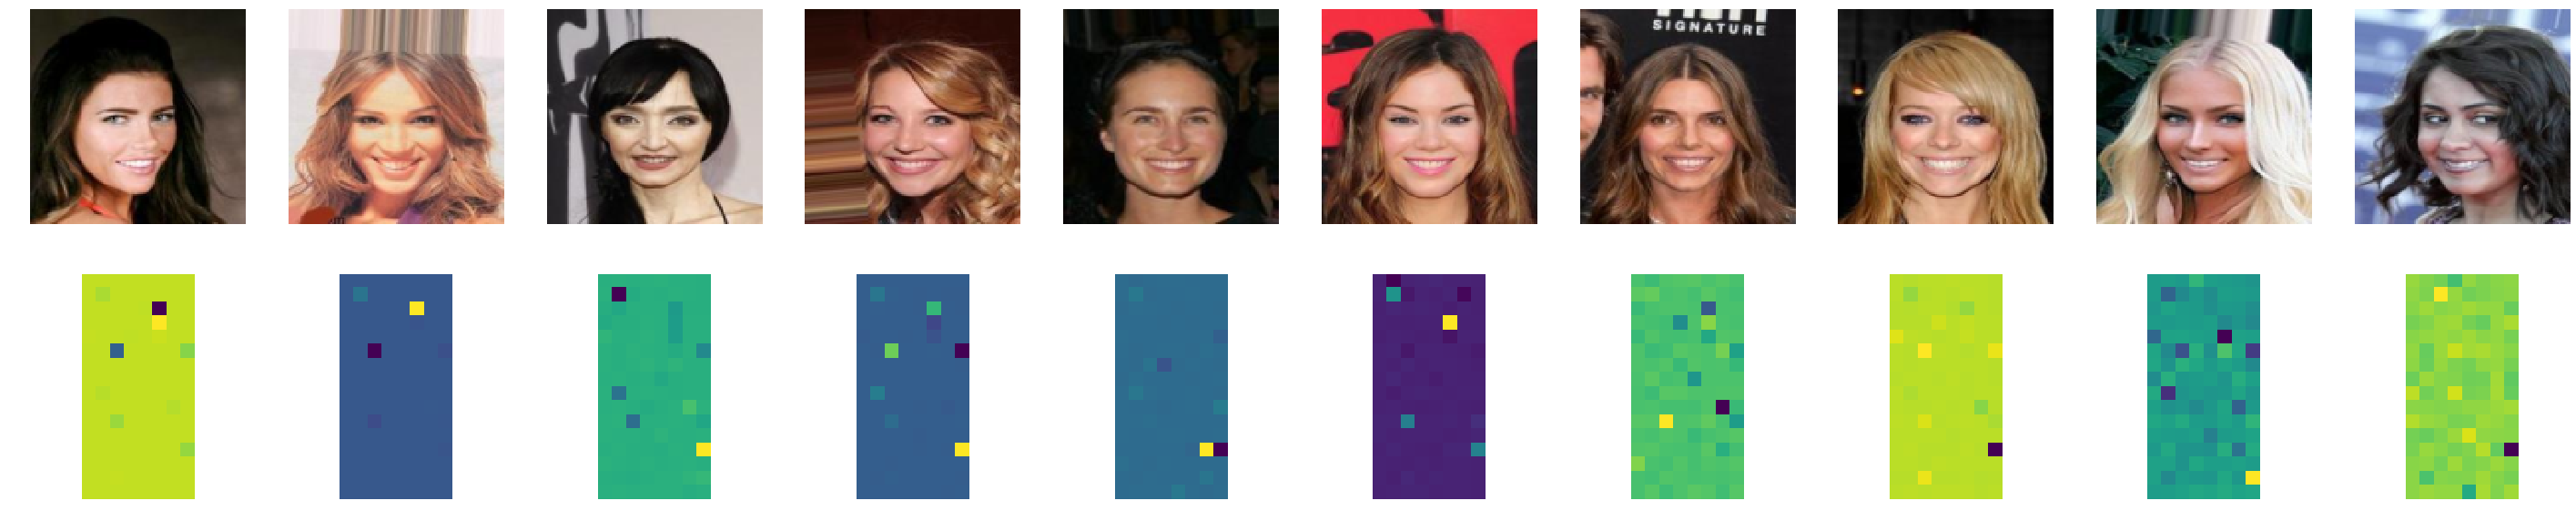

In [37]:
# Plot latent vectors
show_images(lv, seq_start=0)

# Visualize Model

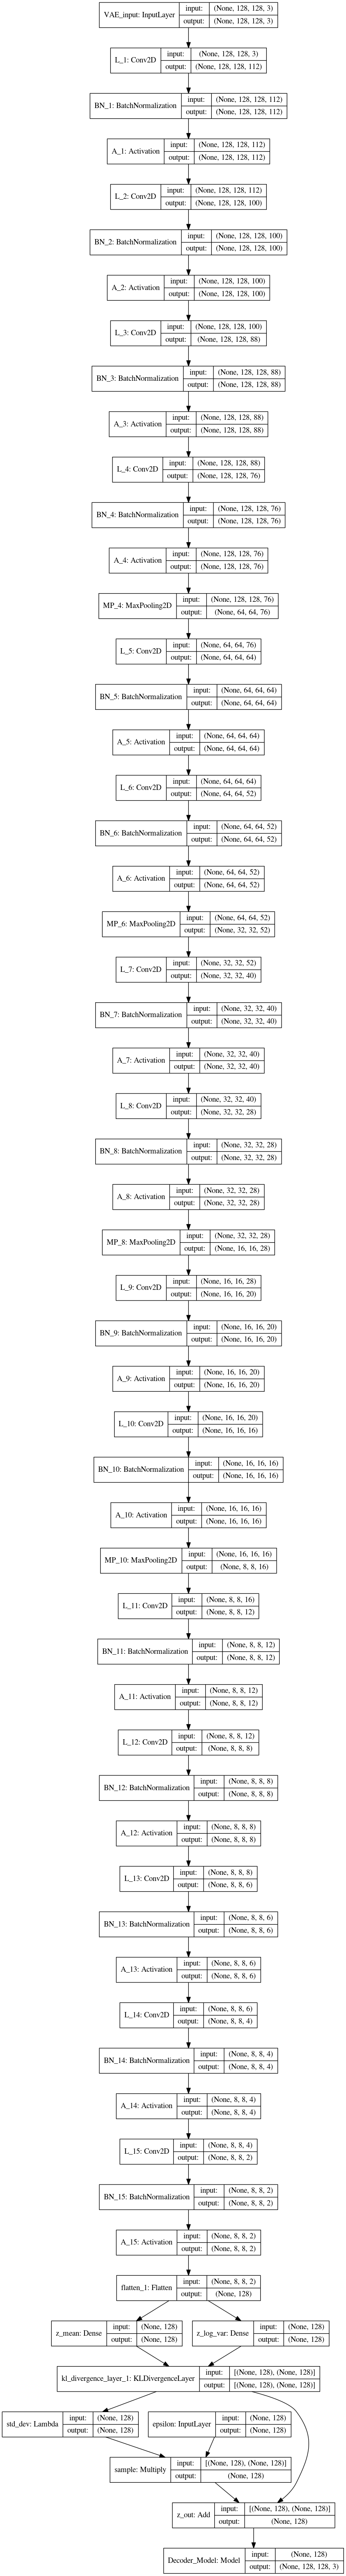

In [38]:
plot_model(vae, to_file='vae.png', show_shapes=True, show_layer_names=True)

# Extras

In [39]:
# e2 = Model(inputs, z_mean)

In [40]:
# y = e2.predict(train, batch_size=250)

In [41]:
# y[:, 0].shape

In [42]:
# z_test = y
# plt.figure(figsize=(6, 6))
# plt.scatter(z_test[:, 0], z_test[:, 1],
#             alpha=.4, s=3**2, cmap='viridis')
# # plt.colorbar()
# plt.show()